In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [7]:
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1960,10,1960.7896,313.83,316.83,-1,-9.99,-0.99
1,1960,11,1960.8743,315.00,316.88,-1,-9.99,-0.99
2,1960,12,1960.9563,316.19,316.96,-1,-9.99,-0.99
3,1961,1,1961.0411,316.89,316.86,-1,-9.99,-0.99
4,1961,2,1961.1260,317.70,317.08,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
754,2023,8,2023.6250,419.68,421.57,21,0.45,0.19
755,2023,9,2023.7083,418.51,421.96,18,0.30,0.14
756,2023,10,2023.7917,418.82,422.11,27,0.47,0.17
757,2023,11,2023.8750,420.46,422.43,21,0.91,0.38


In [8]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

/tmp/ipykernel_1882852/1556785423.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))


In [9]:
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
1960-10-01,1960,10,1960.7896,313.83,316.83,-1,-9.99,-0.99
1960-11-01,1960,11,1960.8743,315.00,316.88,-1,-9.99,-0.99
1960-12-01,1960,12,1960.9563,316.19,316.96,-1,-9.99,-0.99
1961-01-01,1961,1,1961.0411,316.89,316.86,-1,-9.99,-0.99
1961-02-01,1961,2,1961.1260,317.70,317.08,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
2023-08-01,2023,8,2023.6250,419.68,421.57,21,0.45,0.19
2023-09-01,2023,9,2023.7083,418.51,421.96,18,0.30,0.14
2023-10-01,2023,10,2023.7917,418.82,422.11,27,0.47,0.17
2023-11-01,2023,11,2023.8750,420.46,422.43,21,0.91,0.38


<AxesSubplot:>

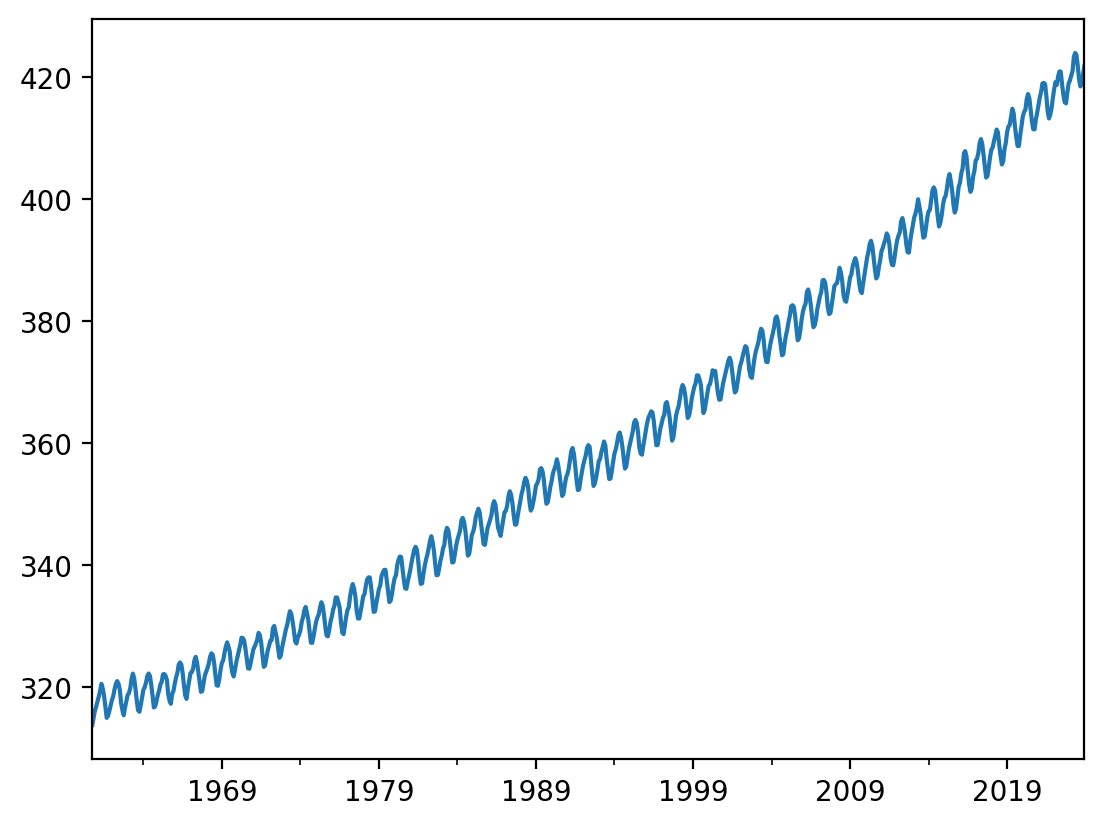

In [10]:
df.average.plot()

(471, 288)

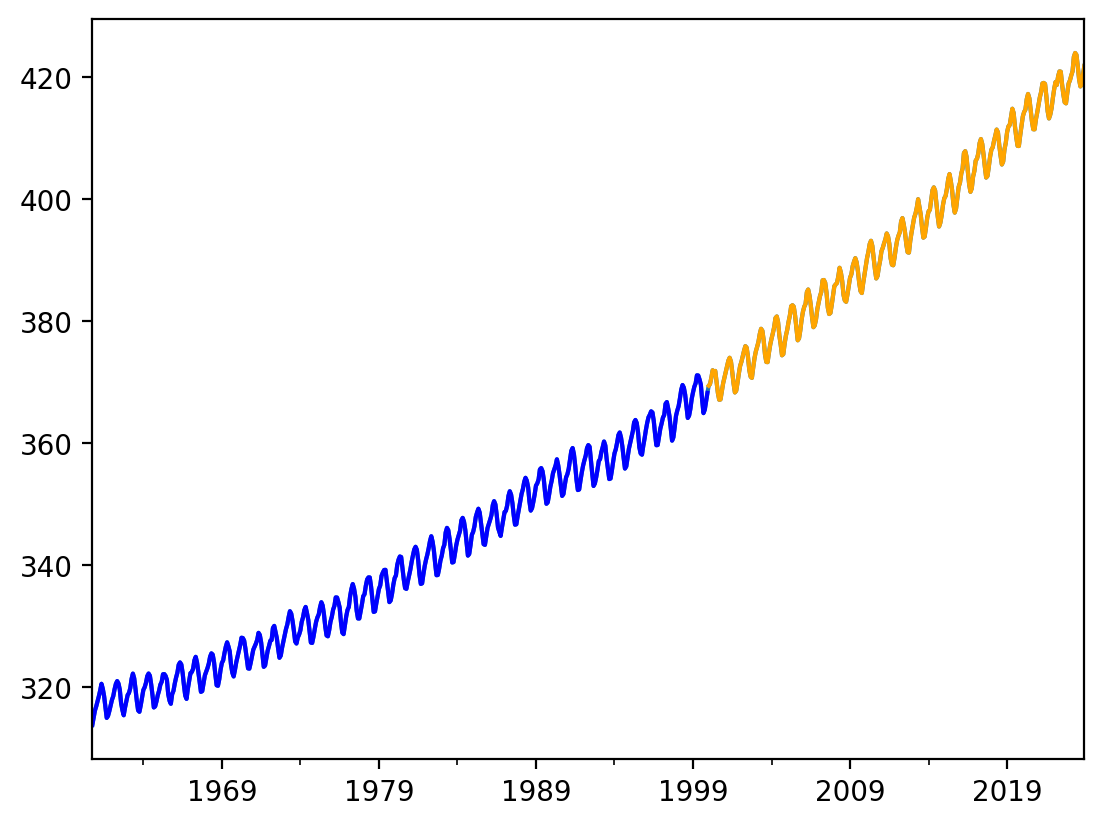

In [14]:
train_cutoff = 2000
train = df[df.year < train_cutoff]
test = df[df.year >= train_cutoff]
df.average.plot()


train.average.plot(color='blue')
test.average.plot(color='orange')

len(train), len(test)

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
months_from_start = range(len(df))
months_from_start = np.array(months_from_start).reshape(-1, 1)

### Model 1: Vanilla Linear Regression

Text(0.5, 1.0, 'Train RMSE: 2.53, Test RMSE: 13.04')

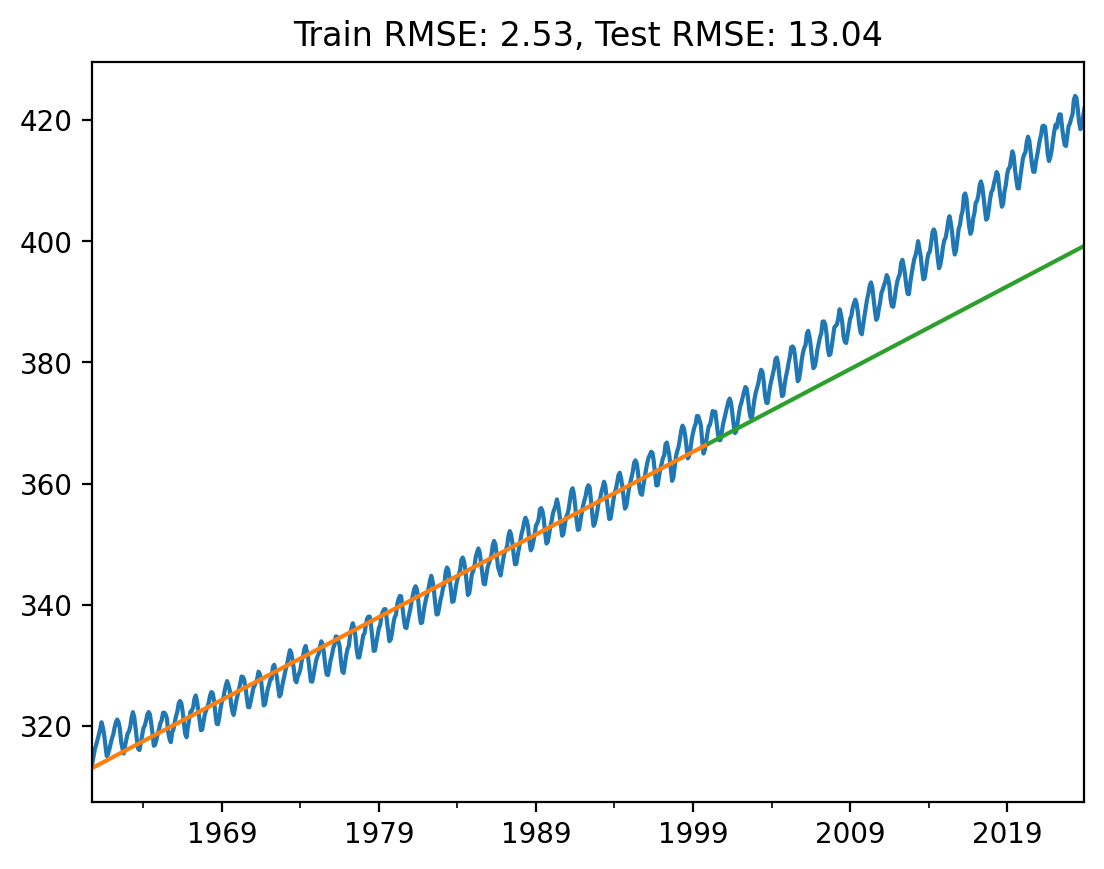

In [44]:

lr1 = LinearRegression()
lr1.fit(months_from_start[:len(train)], train.average.values)
yhat1_test = lr1.predict(months_from_start[len(train):])
yhat1_train = lr1.predict(months_from_start[:len(train)])

yhat_train = pd.Series(yhat1_train, index=train.index)
yhat_test = pd.Series(yhat1_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [45]:
# Polynomial regression with degree d
from sklearn.preprocessing import PolynomialFeatures

def poly_regression(d, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    X_train = pf.fit_transform(months_from_start[:len(train)])
    X_test = pf.fit_transform(months_from_start[len(train):])
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    df.average.plot()
    yhat_train.plot()
    yhat_test.plot()
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

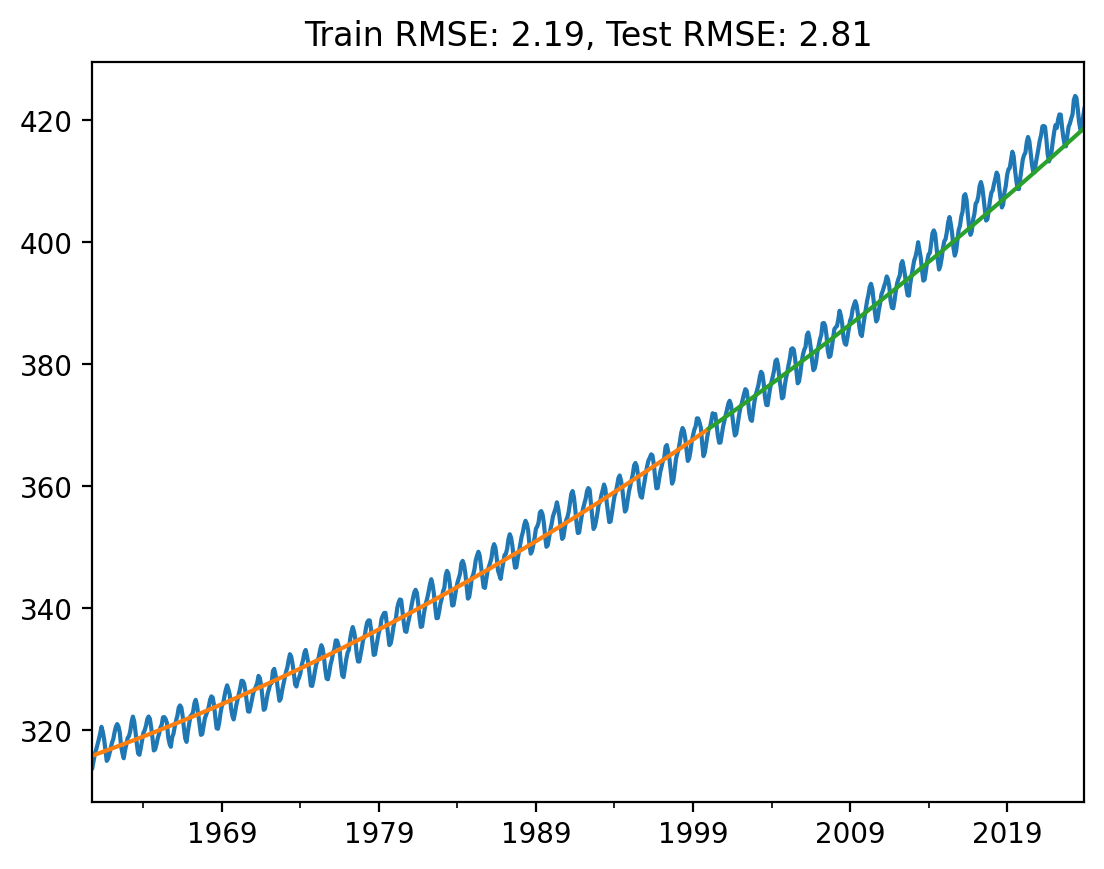

In [50]:
poly_regression(2, train, test)

In [58]:
### Adding sine and cosine terms
def sine_cosine_features(X, n):
    """
    X: array of shape (n_samples, 1)
    n: number of sine and cosine features to add
    """
    for i in range(1, n+1):
        X = np.hstack([X, np.sin(i*X), np.cos(i*X)])
    return X

In [62]:
X = np.linspace(-1, 1, 100).reshape(-1, 1)


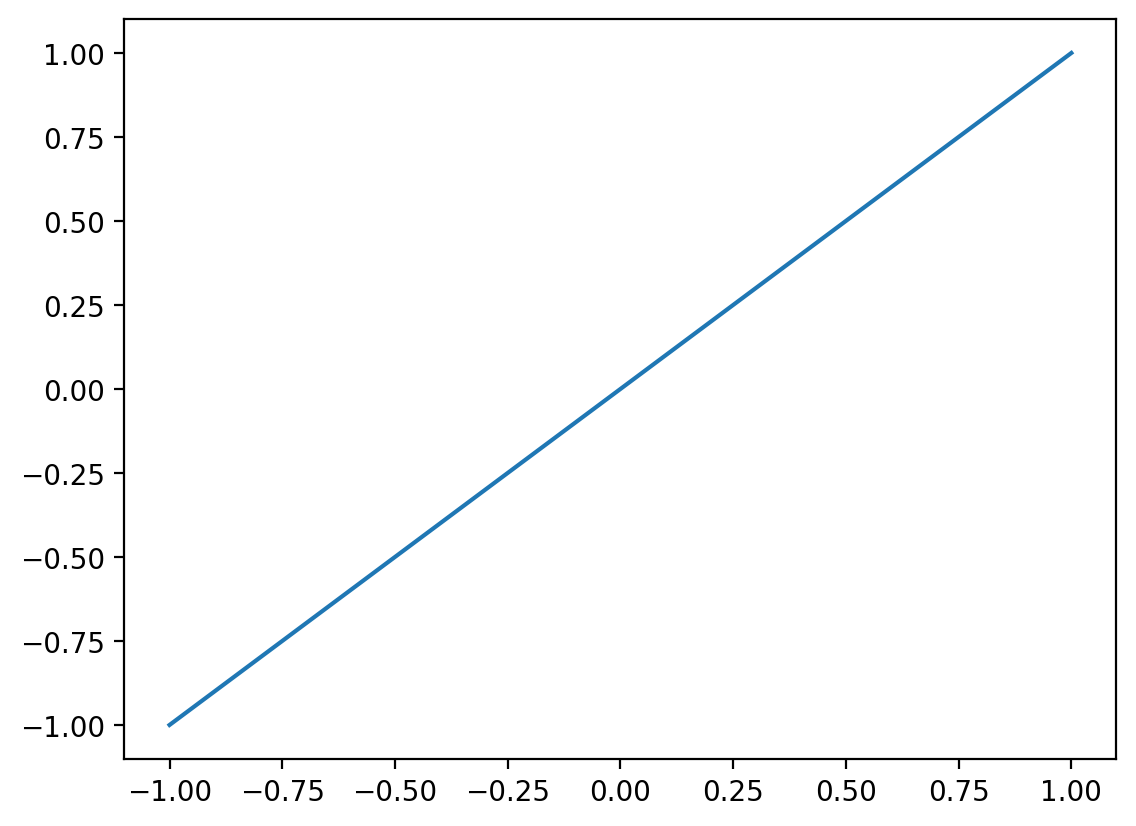

In [93]:
_ = plt.plot(X, sine_cosine_features(X, 0))

In [103]:
def poly_sine_cosine_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = sine_cosine_features(months_from_start[:len(train)], n)
    
    X_test = sine_cosine_features(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

(471, 729) (288, 729)


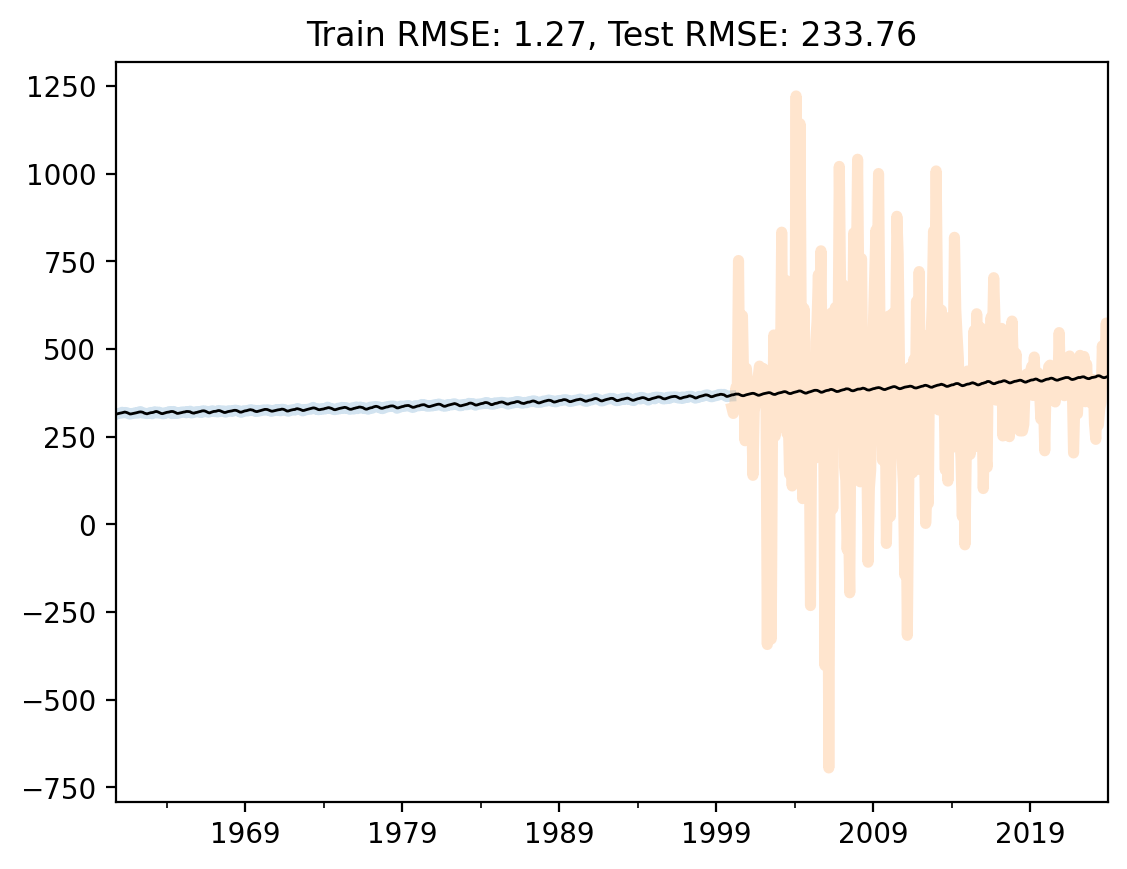

In [115]:
poly_sine_cosine_regression(6, train, test)

### Random Fourier Features

In [116]:
def rff_featurise(X, n_components=100):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    from sklearn.kernel_approximation import RBFSampler
    rbf_feature = RBFSampler(gamma=1, n_components=n_components, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

In [117]:
def poly_rff_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = rff_featurise(months_from_start[:len(train)], n)
    
    X_test = rff_featurise(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

(471, 440) (288, 440)


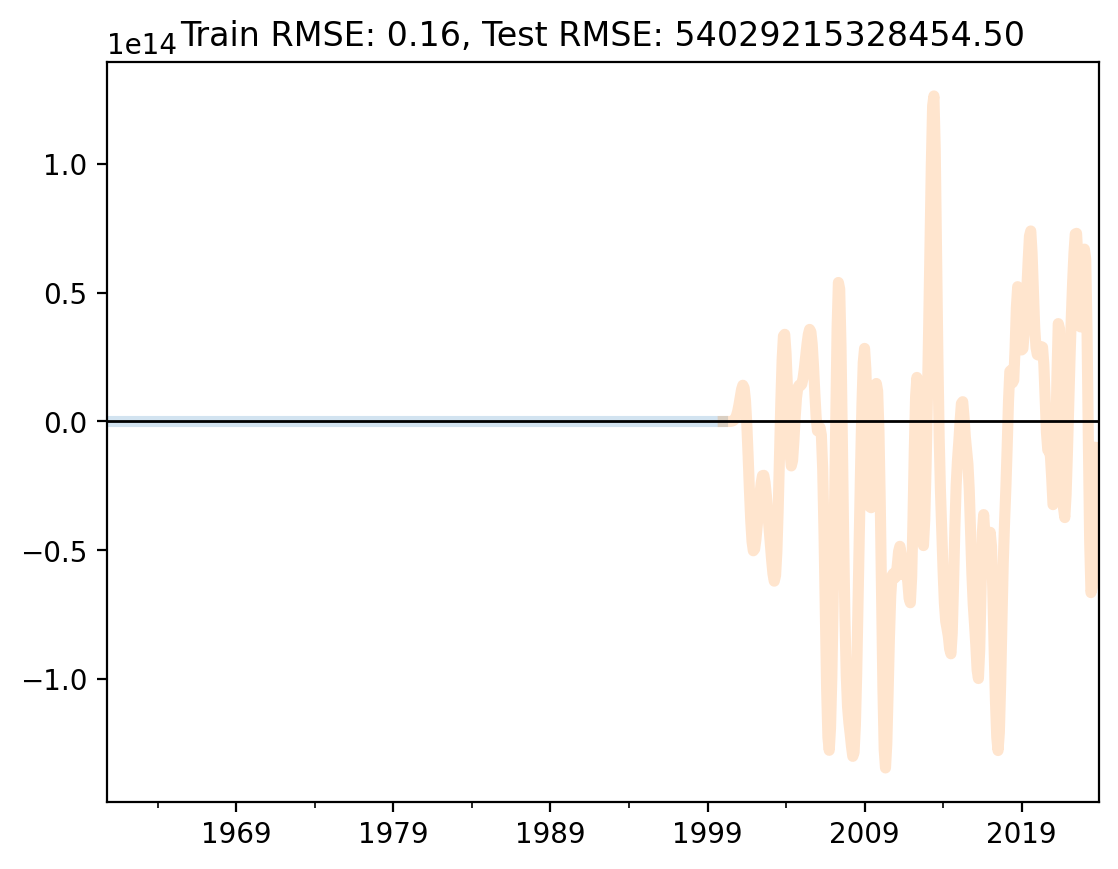

In [127]:
poly_rff_regression(440, train, test)